# Pipeline for High-z Radio Galaxies 11: Redshift prediction

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [22]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [23]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
filter_confirmed = full_catalog_df.loc[:, 'is_AGN'] == 1
filter_redshift  = (full_catalog_df.loc[:, 'Z'] > 0) | (full_catalog_df.loc[:, 'zsp'] > 0)
filter_radio     = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df  = full_catalog_df.loc[filter_confirmed & filter_redshift & filter_radio]

In [24]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 9,225 elements,
9,225 of them are marked as AGN, 0 have been indentified as galaxies, and 9,225 are identified as radio detections.


---

Combine redshift values (AGN + galaxies).

In [25]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

## Possible correlations

In [26]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [27]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [28]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [29]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'radio_detect', 'zsp'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [30]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [31]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [32]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [33]:
# train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
#                                                 random_state=seed, stratify=None)
train_test_df = full_catalog_df.loc[np.isfinite(full_catalog_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
validation_df = full_catalog_df.drop(train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (9225, 39)
Data for Modeling (Train and Test): (7380, 39)
Unseen Data For Validation: (1845, 39)
----------------------------------------


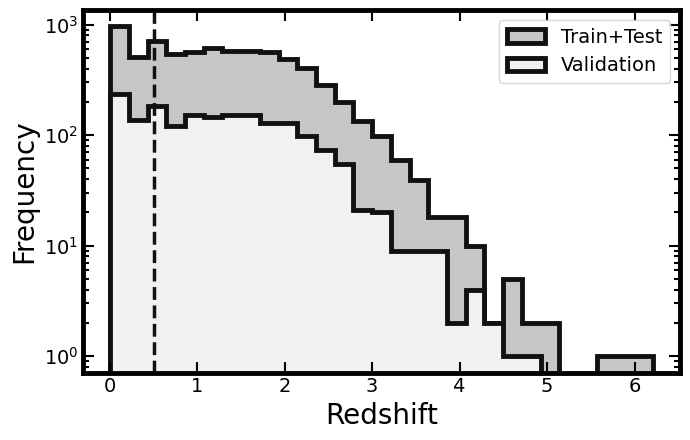

In [34]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [35]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [36]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [37]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [38]:
rsd_vals

z_y         297.343074
i_z         250.880482
w1_w2       142.210299
r_i         137.169599
g_r         113.966837
g_i          95.246714
Z            68.283304
w2_w3        39.914257
J_H          33.895345
H_K          33.524109
w3_w4        25.996635
band_num     17.784968
W1mproPM      7.071574
W2mproPM      6.745856
gmag          6.732366
ymag          6.631762
rmag          6.617645
imag          6.574679
zmag          6.462214
w1/w4         5.811414
g/J           5.784473
i/K           5.595640
w2/w4         5.446554
r/H           5.428317
W3mag         4.799001
w1/w3         4.327016
y/W2          4.048017
z/W1          3.899510
NUVmag        3.196411
W4mag         3.182329
Hmag          3.098002
Jmag          3.007040
FUV/K         2.543265
i/y           2.350318
r/z           2.300232
Kmag          2.266753
FUVmag        1.303657
J/K           1.081665
FUV_NUV     -67.193944
dtype: float64

In [39]:
correlation = norm_train_test_df.corr()

In [40]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [41]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [42]:
target_feat = 'Z'

In [43]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [44]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [45]:
list_drop_corr

['Jmag',
 'Kmag',
 'imag',
 'W2mproPM',
 'rmag',
 'zmag',
 'w2/w4',
 'FUV_NUV',
 'r/H',
 'J/K',
 'w1/w3',
 'g/J',
 'w1/w4',
 'i/K',
 'Hmag',
 'W4mag',
 'ymag',
 'W3mag',
 'g_i',
 'W1mproPM']

In [46]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [47]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [48]:
corr_discard = norm_train_test_discard.corr()

In [49]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
NUVmag    FUVmag      0.688668
y/W2      z/W1        0.676564
z_y       i/y         0.663473
band_num  gmag        0.661596
r_i       r/z         0.624153
i_z       r/z         0.622622
gmag      w3_w4       0.600922
w3_w4     band_num    0.594458
w2_w3     gmag        0.570398
          band_num    0.559555
H_K       FUV/K       0.555625
gmag      NUVmag      0.543381
H_K       band_num    0.541774
Z         z/W1        0.522630
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

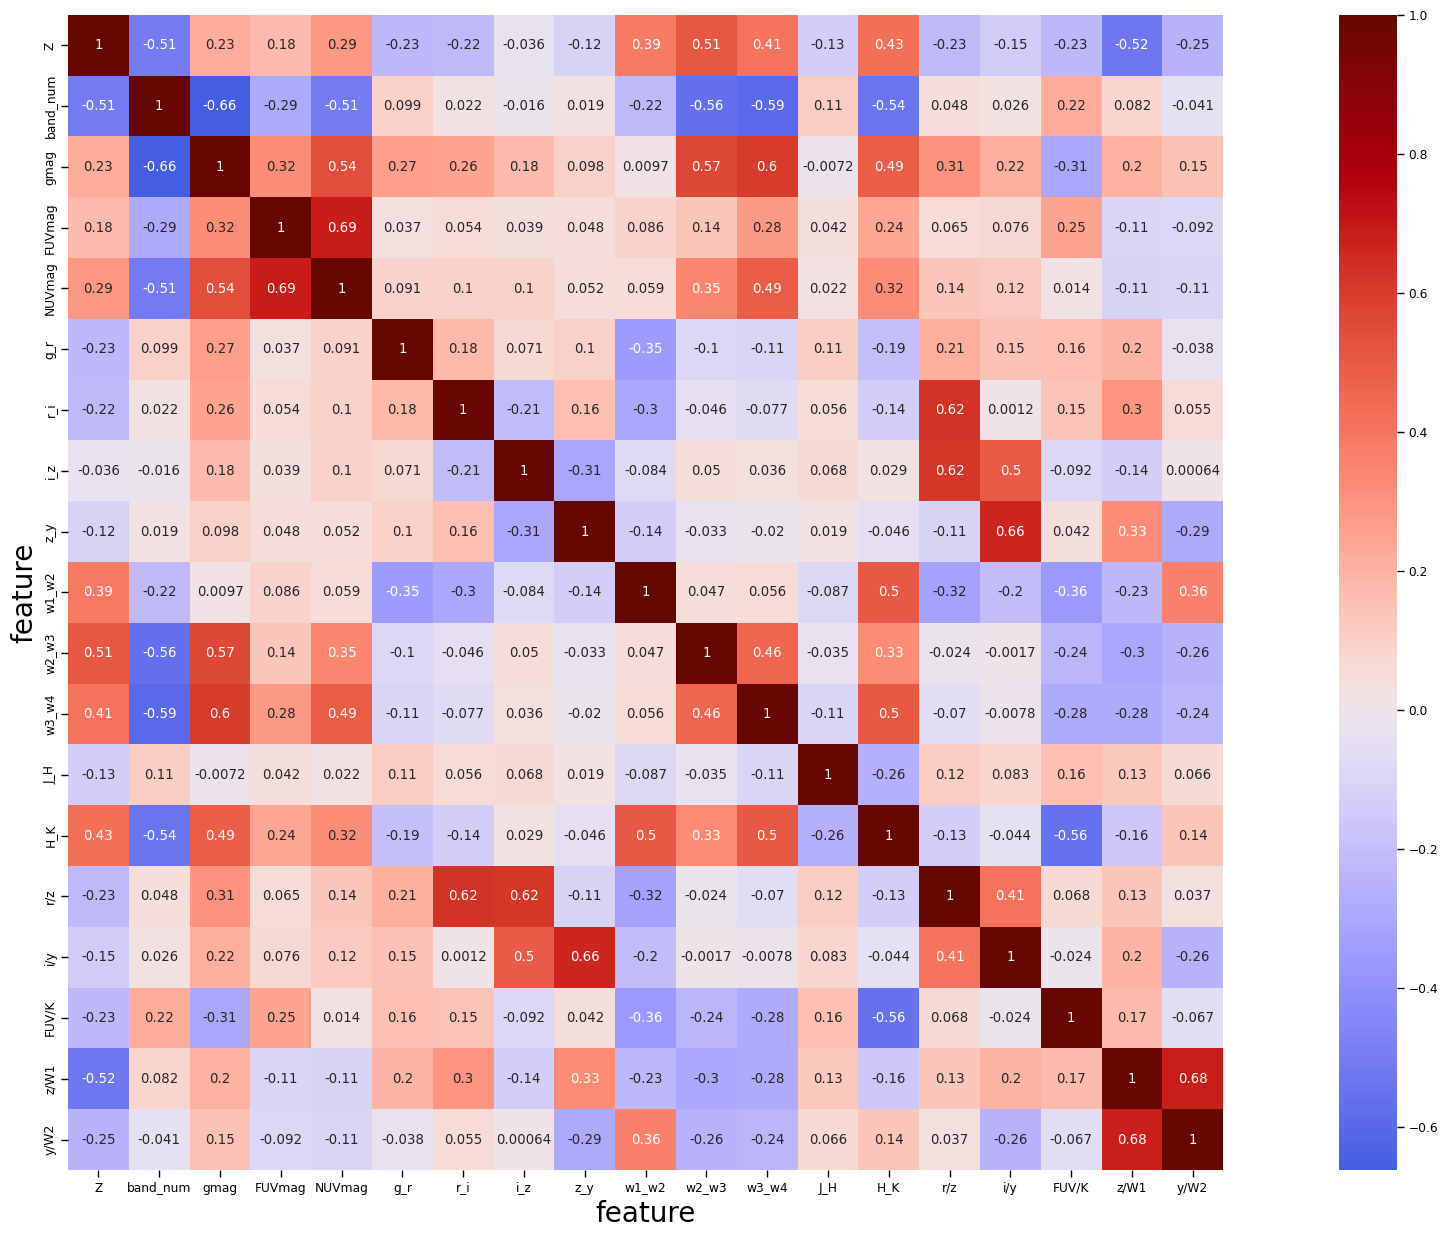

In [50]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [51]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [52]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [53]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
Z         H_K         0.408819
J_H       H_K         0.350826
NUVmag    FUVmag      0.341121
band_num  gmag        0.305503
J_H       band_num    0.279081
H_K       band_num    0.260805
FUV/K     H_K         0.244163
band_num  w3_w4       0.235046
          H_K         0.226083
          w2_w3       0.216893
          Z           0.215872
FUV/K     band_num    0.204351
NUVmag    band_num    0.185100
FUV/K     FUVmag      0.180697
band_num  NUVmag      0.166978
H_K       Z           0.159589
NUVmag    gmag        0.153278
J_H       Z           0.150063
FUV/K     Z           0.140079
dtype: float64

In [54]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [55]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [56]:
target_feat = 'Z'

In [57]:
list_drop_pps = []

In [58]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [59]:
list_drop_pps

[]

In [60]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [61]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [62]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.215872,regression,True,mean absolute error,0.116813,0.091596,DecisionTreeRegressor()
1,H_K,Z,0.159589,regression,True,mean absolute error,0.116813,0.098170,DecisionTreeRegressor()
2,J_H,Z,0.150063,regression,True,mean absolute error,0.116813,0.099283,DecisionTreeRegressor()
3,FUV/K,Z,0.140079,regression,True,mean absolute error,0.116813,0.100450,DecisionTreeRegressor()
4,w1_w2,Z,0.026950,regression,True,mean absolute error,0.116813,0.113664,DecisionTreeRegressor()
5,FUVmag,Z,0.026639,regression,True,mean absolute error,0.116813,0.113701,DecisionTreeRegressor()
6,NUVmag,Z,0.015299,regression,True,mean absolute error,0.116813,0.115025,DecisionTreeRegressor()
7,w3_w4,Z,0.003775,regression,True,mean absolute error,0.116813,0.116372,DecisionTreeRegressor()
8,gmag,Z,0.000000,regression,True,mean absolute error,0.116813,0.147941,DecisionTreeRegressor()
9,g_r,Z,0.000000,regression,True,mean absolute error,0.116813,0.134762,DecisionTreeRegressor()


---

In [63]:
['band_num', 'gmag', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2',
       'w2_w3', 'w3_w4', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1', 'y/W2']

['band_num',
 'gmag',
 'NUVmag',
 'g_r',
 'r_i',
 'i_z',
 'z_y',
 'w1_w2',
 'w2_w3',
 'w3_w4',
 'H_K',
 'r/z',
 'i/y',
 'FUV/K',
 'z/W1',
 'y/W2']

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [64]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('J_H')  # After Boruta
final_feats.remove('FUVmag')  # After Boruta

In [65]:
feats_2_discard = list_drop_corr + list_drop_pps + ['J_H', 'FUVmag']

Boruta discards one feature.

In [66]:
exp_radio = pyr.setup(data=train_test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(7380, 39)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5165, 16)"


In [67]:
pyr.get_config('X').columns

Index(['band_num', 'gmag', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2',
       'w2_w3', 'w3_w4', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1', 'y/W2'],
      dtype='object')

In [68]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [69]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f3ebdc9f430>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [71]:
final_selection_reg  = ['rf', 'et', 'dt', 'lightgbm', 'catboost', 'dummy']  # knn discarded: no feature importances
n_models             = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='s_nmad')  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, exclude=['knn'], sort='s_nmad')  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2755,0.2285,0.4765,0.7045,0.1998,0.5298,0.2071,0.0912,0.4765,0.2326,0.2436,0.2830
et,Extra Trees Regressor,0.2717,0.2115,0.4588,0.7264,0.1921,0.4953,0.2134,0.0972,0.4588,0.2212,0.2445,0.1160
dt,Decision Tree Regressor,0.3796,0.4581,0.6738,0.4054,0.2766,0.5916,0.2443,0.1106,0.6738,0.3495,0.3011,0.0170
lightgbm,Light Gradient Boosting Machine,0.2813,0.2124,0.4598,0.7253,0.1931,0.5473,0.2393,0.1111,0.4598,0.2180,0.2629,27.6030
catboost,CatBoost Regressor,0.2817,0.2118,0.4593,0.7258,0.1930,0.5786,0.2428,0.1133,0.4593,0.2205,0.2590,0.5640
xgboost,Extreme Gradient Boosting,0.3018,0.2384,0.4875,0.6913,0.2064,0.6196,0.2594,0.1215,0.4875,0.2385,0.2894,9.3650
gbr,Gradient Boosting Regressor,0.3208,0.2471,0.4965,0.6802,0.2078,0.6334,0.2978,0.1389,0.4965,0.2383,0.3156,0.1940
huber,Huber Regressor,0.3880,0.3305,0.5743,0.5735,0.2398,1.3032,0.3914,0.1875,0.5743,0.2718,0.4316,0.0150
ridge,Ridge Regression,0.3953,0.3237,0.5684,0.5821,0.2444,1.3364,0.4111,0.1935,0.5684,0.2888,0.4484,0.0090
lr,Linear Regression,0.3953,0.3237,0.5684,0.5821,0.2444,1.3390,0.4116,0.1935,0.5684,0.2889,0.4480,0.2210


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [72]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize='s_nmad')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2524,0.1882,0.4339,0.7679,0.1874,0.4242,0.1767,0.0745,0.4339,0.2238,0.2031
1,0.2636,0.2236,0.4728,0.7056,0.1915,0.5133,0.1903,0.0850,0.4728,0.2060,0.2244
2,0.2713,0.2485,0.4985,0.6738,0.2082,0.4218,0.1890,0.0800,0.4985,0.2278,0.2282
3,0.2562,0.2010,0.4483,0.7650,0.1832,0.5231,0.1735,0.0816,0.4483,0.2218,0.2012
4,0.2612,0.1934,0.4398,0.7282,0.1987,0.5130,0.1741,0.0811,0.4398,0.2391,0.2379
5,0.2556,0.2226,0.4719,0.7333,0.1970,0.5648,0.1674,0.0781,0.4719,0.2445,0.2151
6,0.2569,0.2343,0.4841,0.6861,0.1968,0.5180,0.1795,0.0814,0.4841,0.2279,0.2171
7,0.2460,0.1922,0.4384,0.7454,0.1850,0.4368,0.1812,0.0827,0.4384,0.2271,0.2054
8,0.2300,0.1654,0.4067,0.7797,0.1671,0.4391,0.1776,0.0797,0.4067,0.1767,0.1919


In [73]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize='s_nmad',\
                               search_library='tune-sklearn', search_algorithm='random')  # 1h30

Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.
Trial _Trainable_f5b69_00007: Error processing event.


RayTaskError(ValueError): joblib.externals.loky.process_executor._RemoteTraceback: 
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 170, in _parallel_build_trees
    tree.fit(X, y, sample_weight=sample_weight, check_input=False)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1242, in fit
    super().fit(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 255, in fit
    raise ValueError("Invalid value for max_features. "
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.
"""

The above exception was the direct cause of the following exception:

[36mray::_Trainable.train()[39m (pid=28294, ip=194.117.9.85, repr=<tune_sklearn._trainable._Trainable object at 0x7fd2ec53f9a0>)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/ray/tune/trainable.py", line 315, in train
    result = self.step()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 106, in step
    return self._train()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/tune_sklearn/_trainable.py", line 237, in _train
    scores = cross_validate(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 680, in fit
    return super().fit(X, y, sample_weight)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_stacking.py", line 195, in fit
    _fit_single_estimator(self.final_estimator_, X_meta, y,
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_base.py", line 40, in _fit_single_estimator
    estimator.fit(X, y)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/concurrent/futures/_base.py", line 444, in result
    return self.__get_result()
  File "/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result
    raise self._exception
ValueError: Invalid value for max_features. Allowed string values are 'auto', 'sqrt' or 'log2'.

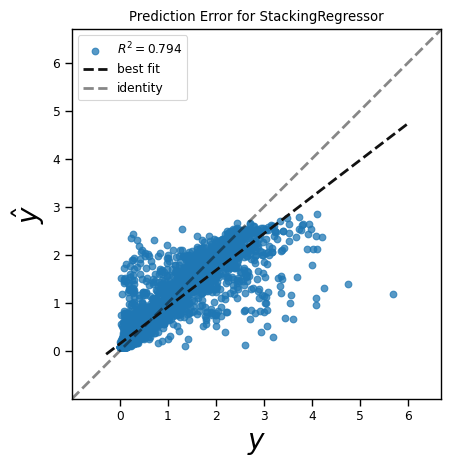

In [72]:
pyr.plot_model(tuned_z_reg, plot='error')

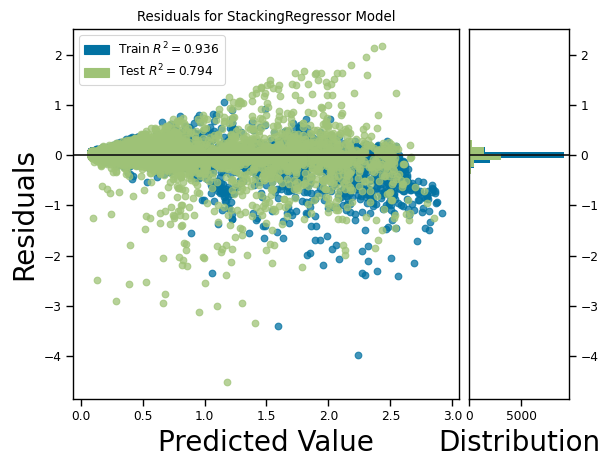

In [73]:
pyr.plot_model(tuned_z_reg, plot='residuals')

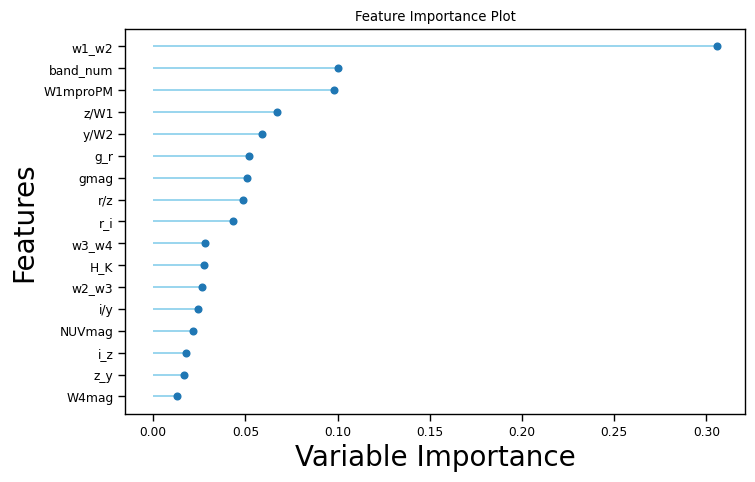

In [74]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [76]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mae
max_depth,8
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.001
min_impurity_split,None
min_samples_leaf,3


In [77]:
plt.rcParams.update(plt.rcParamsDefault)

In [78]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1439,0.1043,0.3230,0.7938,0.1364,0.3567,0.0715,0.0483,0.3230,0.1494,0.1141


,band_num,W1mproPM,gmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,w3_w4,H_K,r/z,i/y,z/W1,y/W2,Z,Label
0,-0.884574,-0.164729,1.521038,0.499283,0.361896,1.564680,0.144565,0.371520,0.468499,-1.805098,0.112577,0.719707,0.502745,0.352731,0.691566,1.137723,0.299592,0.63588,0.598837
1,-0.456427,1.401727,-0.037422,0.499283,0.361896,0.411972,0.337292,0.080215,-0.154085,-0.012103,1.526543,0.719707,0.502745,0.422419,-0.029657,-2.182946,-2.141448,0.29691,0.316183
2,1.604430,-0.086955,-0.732321,-2.086370,0.361896,-0.414895,-0.353753,0.356514,-0.893789,-0.199379,0.682707,-1.341106,-0.563496,0.020913,-0.396175,-0.936671,-0.640671,0.12604,0.131908
3,0.793905,-0.577775,0.524289,0.499283,0.361896,1.221221,-0.054648,-0.057413,0.016260,-0.784216,-0.832989,0.719707,0.502745,-0.105108,-0.039043,0.758897,0.373654,0.47300,0.399155
4,-0.456427,0.850389,0.580238,0.499283,0.361896,1.057619,0.156338,0.295071,-0.156426,-0.856546,1.192212,0.719707,0.502745,0.381982,0.149045,-1.063881,-1.320194,0.44686,0.439299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6087,0.793905,-1.389359,-1.811402,0.499283,-2.881388,-0.613513,-0.401438,-0.000721,-0.094863,1.412010,-0.316903,-1.627757,-1.551162,-0.252454,0.032514,-0.796267,0.089923,2.29600,1.852861
6088,-0.884574,0.359860,1.521038,0.499283,0.361896,2.214070,0.405476,0.249124,0.173476,-1.183503,0.662190,0.719707,0.502745,0.540385,0.366631,-0.047174,-0.585635,0.52077,0.493423
6089,0.793905,-0.560772,-0.961912,0.499283,0.361896,0.097963,-0.382405,-0.432182,-0.064818,-0.401515,-0.665254,-0.405755,-0.852171,-0.695723,-0.453320,-0.667556,-0.895855,0.12000,0.141827
6090,-0.456427,1.060477,-0.573665,0.499283,0.361896,-0.504120,-0.948919,-0.276658,-0.454298,1.337905,0.121899,0.719707,0.502745,-1.101056,-0.662029,-1.088843,-0.139591,1.26400,2.107269


In [79]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1439,0.1043,0.3230,0.7938,0.1364,0.3567,0.0715,0.0483,0.3230,0.1494,0.1141


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [80]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [81]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_may_10_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('models/config_regression_z_may_10_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_may_10_2022')

### Prediction process

#### Feature importances

In [82]:
estimators_list = [estimator[0] for estimator in final_z_reg.estimators]

In [83]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [84]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [85]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [86]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [87]:
base_models_names = [model[0] for model in estimators_list]

In [88]:
coef_sorted_base_df = {}

In [89]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [90]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [91]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for dt...
Calculating for lightgbm...
Calculating for catboost...


et                   dt             lightgbm             catboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  31.392831     w1_w2  42.478272     w1_w2  12.966667     w1_w2   
1   band_num  10.300769      z/W1  10.307611       g_r   9.100000      z/W1   
2   W1mproPM   9.746362  band_num  10.092522      z/W1   8.100000  band_num   
3       z/W1   6.754678       r_i   8.284663       r/z   8.000000       r/z   
4       y/W2   5.442149  W1mproPM   5.261804       r_i   7.900000       r_i   
5       gmag   5.200660       g_r   4.907579  W1mproPM   6.866667      y/W2   
6        r/z   4.934224      y/W2   4.004437       i_z   6.366667  W1mproPM   
7        g_r   4.679755       r/z   3.811232      y/W2   6.233333       g_r   
8        r_i   4.217110      gmag   2.702001      gmag   5.766667     w2_w3   
9      w3_w4   2.816880       i_z   1.914076     w2_w3   5.766667     w3_w4   
10     w2_w3   2.789117     w2_w3   1.672820  band_num   5.566667      gmag   
11       H_K   2.576480       i/y   1.361802       z_y   5.166667       z_y   
12       i/y   2.260352       z_y   1.282104       i/y   5.066667       i_z   
13    NUVmag   2.175241     w3_w4   0.676021     w3_w4   3.333333       i/y   
14       i_z   1.881236     W4mag   0.458258     W4mag   1.400000       H_K   
15       z_y   1.645485       H_K   0.402631    NUVmag   1.333333    NUVmag   
16     W4mag   1.186671    NUVmag   0.382166       H_K   1.066667     W4mag   

               
   Importance  
0   22.397568  
1   13.344613  
2   11.332995  
3   10.384096  
4    7.135005  
5    6.588438  
6    5.379549  
7    4.875694  
8    3.282111  
9    2.923353  
10   2.546756  
11   2.348567  
12   2.198224  
13   2.094390  
14   1.560536  
15   1.163271  
16   0.444834

In [92]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,catboost,24.206456
1,et,22.274960
2,dt,18.734147
3,lightgbm,13.462218
4,w1_w2,4.424119
5,band_num,3.398570
6,H_K,3.025929
7,w3_w4,2.095008
8,gmag,1.678122
9,z/W1,1.167135


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	13.286
g_r	8.961
z/W1	8.269
r/z	8.075
r_i	7.874
W1mproPM	6.819
y/W2	6.244
i_z	6.229
band_num	5.756
w2_w3	5.684
gmag	5.662
z_y	5.073
i/y	4.969
w3_w4	3.319
W4mag	1.369
NUVmag	1.328
H_K	1.083


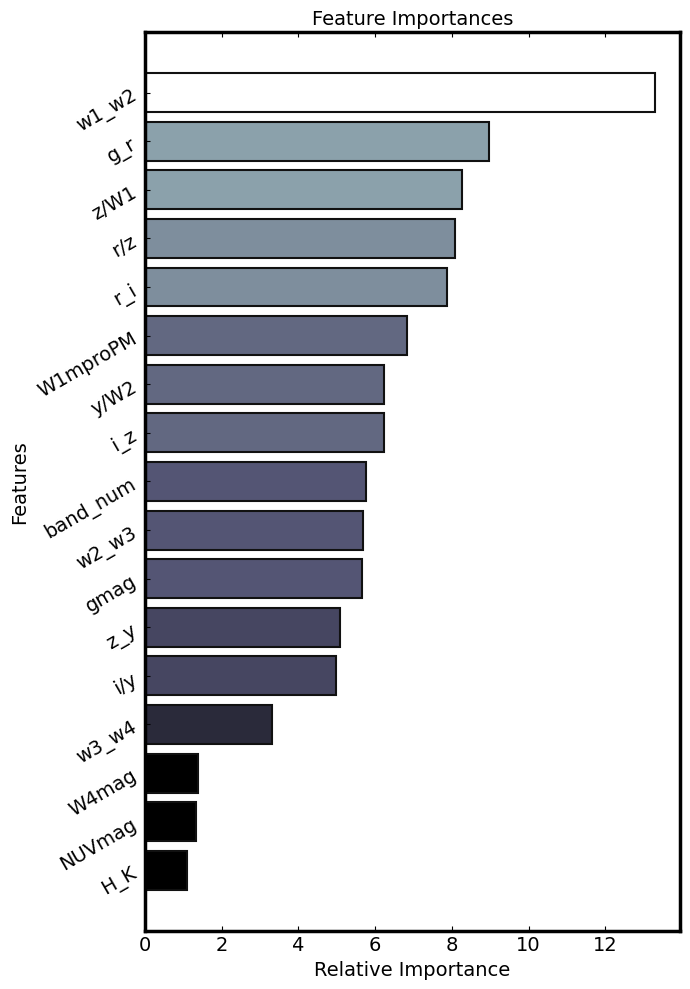

In [93]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_02.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [94]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1347,0.0969,0.3112,0.8136,0.1286,0.3243,0.0693,0.0475,0.3112,0.1328,0.1003


In [95]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,5076.000000,5076.000000
mean,0.719701,0.698530
std,0.721032,0.620765
min,0.007000,0.082280
25%,0.192257,0.197128
50%,0.501595,0.530933
75%,0.875827,0.819950
max,5.800000,2.830057


In [128]:
# clb.vmax

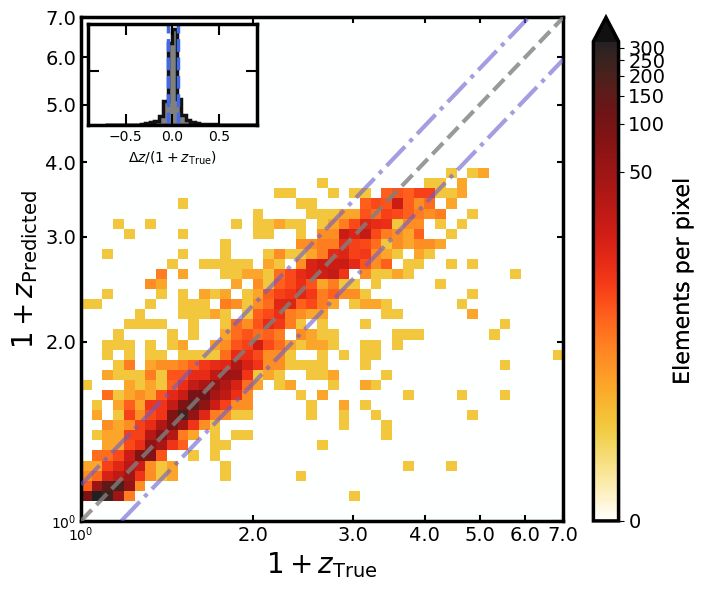

In [126]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 331
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(validation_prediction_reg.loc[:, 'Z']) & np.isfinite(validation_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + validation_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + validation_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (validation_prediction_reg.loc[:, 'Label'] - validation_prediction_reg.loc[:, 'Z']) / (1 + validation_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_02.pdf', bbox_inches='tight')
plt.show()

In [97]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['Z']),
                train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [98]:
train_prediction_reg = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg  = pyr.predict_model(final_z_reg, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0801,0.0347,0.1863,0.9306,0.0705,0.2273,0.0503,0.0340,0.1863,0.0698,0.0400


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0822,0.0345,0.1856,0.9319,0.0715,0.2163,0.0512,0.0335,0.1856,0.0715,0.0442


In [99]:
sigma_mad_train    = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test     = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid    = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [100]:
sigma_nmad_train   = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test    = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid   = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [101]:
sigma_z_train      = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test       = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_valid      = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [102]:
sigma_z_norm_train = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test  = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [103]:
out_frac_train     = outlier_frac(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
out_frac_test      = outlier_frac(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
out_frac_valid     = outlier_frac(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [104]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0503
Sigma NMAD:		0.0340
Sigma z:		0.1863
Sigma z norm:		0.0698
Out fraction:		0.0400
-----------------------------------


In [105]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.0512
Sigma NMAD:		0.0335
Sigma z:		0.1856
Sigma z norm:		0.0715
Out fraction:		0.0442
-----------------------------------


In [106]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.0693
Sigma NMAD:		0.0475
Sigma z:		0.3112
Sigma z norm:		0.1328
Out fraction:		0.1003
-----------------------------------


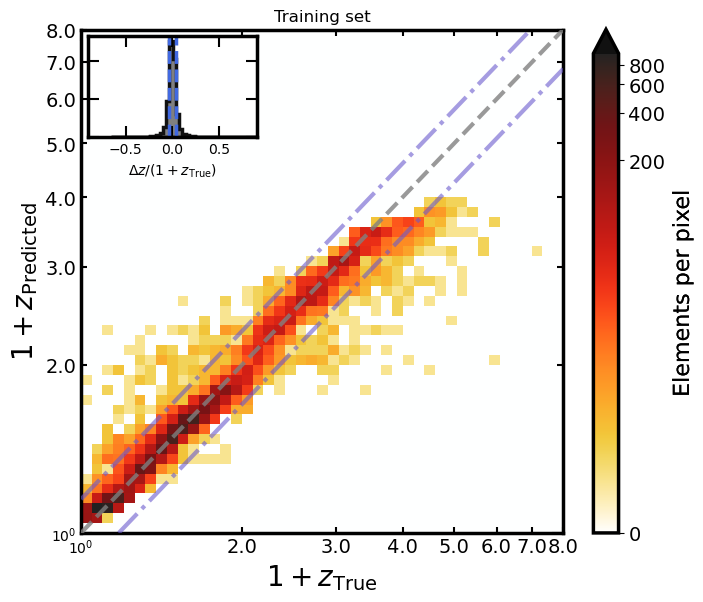

In [141]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 947
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(train_prediction_reg.loc[:, 'Z']) & np.isfinite(train_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + train_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + train_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (train_prediction_reg.loc[:, 'Label'] - train_prediction_reg.loc[:, 'Z']) / (1 + train_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Training set')
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_redshift_02.pdf', bbox_inches='tight')
plt.show()

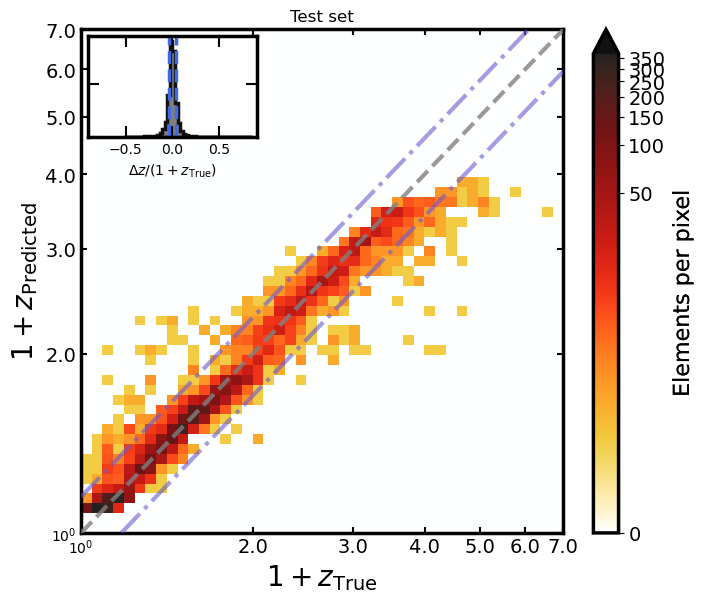

In [140]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 388
norm = ImageNormalize(vmin=0., stretch=LogStretch())

filt_pair_z = np.isfinite(test_prediction_reg.loc[:, 'Z']) & np.isfinite(test_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + test_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + test_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (test_prediction_reg.loc[:, 'Label'] - test_prediction_reg.loc[:, 'Z']) / (1 + test_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Test set')
if save_plot_flag:
    plt.savefig('plots/compare_plot_test_redshift_02.pdf', bbox_inches='tight')
plt.show()

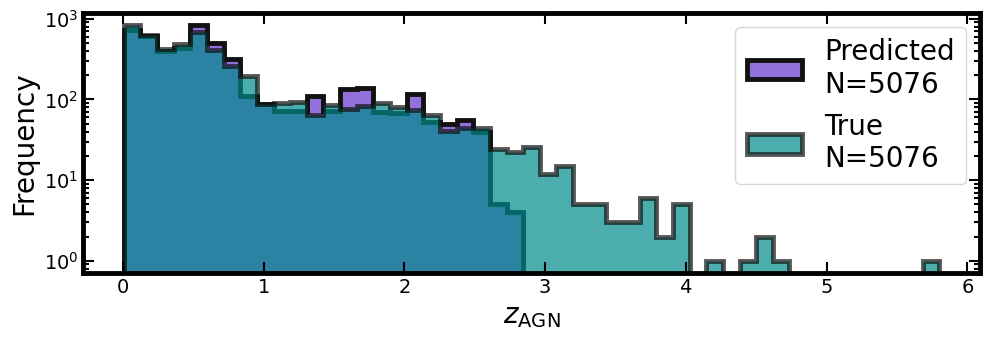

In [127]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_02.pdf')
plt.show()